# Playground for Multi-Agent Reinforcement Learning (MARL)

In [1]:
import torch
import numpy as np

# Tensordict modules
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import multiprocessing

# Data collection
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

# Env
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs

# Multi-agent network
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal

# Loss
from torchrl.objectives import ClipPPOLoss, ValueEstimators

# Utils
torch.manual_seed(0)
import matplotlib.pyplot as plt
from tqdm import tqdm

ModuleNotFoundError: No module named 'torch'

In [2]:
# Hyperparameters

# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = ( torch.device(0) if torch.cuda.is_available() and not is_fork else torch.device("cpu") )
vmas_device = device

# Sampling
frames_per_batch = 3500 # No. of team frames collected per training iter
n_iters = 20 # No. of sampling and training iters
total_frames = frames_per_batch * n_iters

# Training
n_epochs = 40 # No. of optimisation steps per training iter
minibatch_sz = 400 # Size of the minibatches in each optimisation step
lr = 4e-4 # Learning rate
max_grad_norm = 1.0 # Maximum norm for the gradients

# PPO
clip_epsilon = 0.2 # clip value for PPO loss
gamma = 0.92 # discount factor
lmbda = 0.9 # lambda for generalised advantage estimation
entropy_eps = 1e-4 # coefficient of the entropy term in the PPO loss

In [3]:
# Environment

max_steps = 1000
num_vmas_envs = ( frames_per_batch // max_steps )
scenario_name = "navigation"
n_agents = 4

env = VmasEnv(
    scenario=scenario_name,
    num_envs=num_vmas_envs,
    continuous_actions=True,
    max_steps=max_steps,
    device=vmas_device,
    n_agents=n_agents,
)

In [4]:
# Tranforms

env = TransformedEnv(
    env,
    RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")])
)
check_env_specs(env)

2025-02-17 17:53:40,247 [torchrl][INFO] check_env_specs succeeded!


In [5]:
# Rollout

n_rollout_steps = 6
rollout = env.rollout(n_rollout_steps)

In [6]:
# Policy

share_parameters_policy = True
policy_net = torch.nn.Sequential(
    MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
        n_agent_outputs = 2 * env.action_spec.shape[-1],
        n_agents = env.n_agents,
        centralised = False,
        share_params = share_parameters_policy,
        device = device,
        depth = 2,
        num_cells = 256,
        activation_class = torch.nn.Tanh,
    ),
    NormalParamExtractor(),
)

policy_module = TensorDictModule(
    policy_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "loc"), ("agents", "scale")],
)

policy = ProbabilisticActor(
    module = policy_module,
    spec = env.unbatched_action_spec,
    in_keys = [("agents", "loc"), ("agents", "scale")],
    out_keys = [env.action_key],
    distribution_class = TanhNormal,
    distribution_kwargs={
        "low" : env.unbatched_action_spec[env.action_key].space.low,
        "high" : env.unbatched_action_spec[env.action_key].space.high,
    },
    return_log_prob = True,
    log_prob_key = ("agents", "sample_log_prob"),
)

/Users/johnlcj/Documents/Projects/Q.Gates/.q_gates_env/lib/python3.12/site-packages/torchrl/envs/common.py:1105: DeprecationWarning: You are querying a non-trivial, single action_spec, i.e., there is only one action known by the environment but it is not named `'action'`. Currently, env.action_spec returns the leaf but for consistency with the setter, this will return the full spec instead (from v0.8 and on).
  warnings.warn(
/Users/johnlcj/Documents/Projects/Q.Gates/.q_gates_env/lib/python3.12/site-packages/torchrl/envs/libs/vmas.py:374: UserWarning: unbatched_action_spec is deprecated and will be removed in v0.9. Please use full_action_spec_unbatched instead.
  warnings.warn(


In [7]:
# Critic Network

share_parameters_critic = True
mappo = True # IPPO if False

critic_net = MultiAgentMLP(
    n_agent_inputs = env.observation_spec["agents", "observation"].shape[-1],
    n_agent_outputs = 1, # 1 value per agent
    n_agents = env.n_agents,
    centralised = mappo,
    share_params = share_parameters_critic,
    device = device,
    depth = 2,
    num_cells = 256,
    activation_class = torch.nn.Tanh,
)

critic = TensorDictModule(
    module = critic_net,
    in_keys = [("agents", "observation")],
    out_keys = [("agents", "state_value")],
)

In [8]:
# Data collector

collector = SyncDataCollector(
    env,
    policy,
    device=vmas_device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

/Users/johnlcj/Documents/Projects/Q.Gates/.q_gates_env/lib/python3.12/site-packages/torchrl/collectors/collectors.py:748: UserWarning: frames_per_batch (3500) is not exactly divisible by the number of batched environments (3),  this results in more frames_per_batch per iteration that requested (3501). To silence this message, set the environment variable RL_WARNINGS to False.
  warnings.warn(


In [9]:
# Replay buffer

replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch, device=device),
    sampler=SamplerWithoutReplacement(),
    batch_size=minibatch_sz,
)

In [10]:
# Loss function

loss_module = ClipPPOLoss(
    actor_network=policy,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_coef=entropy_eps,
    normalize_advantage=False,
)
loss_module.set_keys(
    reward=env.reward_key,
    action=env.action_key,
    sample_log_prob=("agents", "sample_log_prob"),
    value=("agents", "state_value"),
    done=("agents", "done"),
    terminated=("agents", "terminated"),
)
loss_module.make_value_estimator(ValueEstimators.GAE, gamma=gamma, lmbda=lmbda)
GAE = loss_module.value_estimator
optim = torch.optim.Adam(loss_module.parameters(), lr)

In [11]:
# Training loop

pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")
episode_reward_mean_list = list()
for tensordict_data in collector:
    tensordict_data.set(
        ("next", "agents", "done"),
        tensordict_data.get(("next", "done"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    tensordict_data.set(
        ("next", "agents", "terminated"),
        tensordict_data.get(("next", "terminated"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    with torch.no_grad():
        GAE(
            tensordict_data,
            params=loss_module.critic_network_params,
            target_params=loss_module.target_critic_network_params,
        )
    data_view = tensordict_data.reshape(-1) # flatten
    replay_buffer.extend(data_view)

    for _ in range(n_epochs):
        for _ in range(frames_per_batch // minibatch_sz):
            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata)
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )
            loss_value.backward()
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()
    collector.update_policy_weights_()
    done = tensordict_data.get(("next", "agents", "done"))
    episode_reward_mean = (
        tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
    )
    episode_reward_mean_list.append(episode_reward_mean)
    pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
    pbar.update()

episode_reward_mean = 3.799588441848755: 100%|██████████| 20/20 [01:42<00:00,  5.27s/it] 

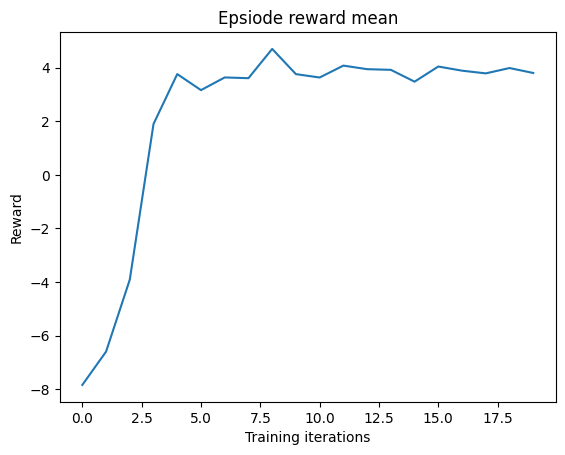

In [12]:
# Plot performance

plt.plot(episode_reward_mean_list)
plt.xlabel("Training iterations")
plt.ylabel("Reward")
plt.title("Epsiode reward mean")
plt.show()

In [13]:
with torch.no_grad():
    env.rollout(
        max_steps=max_steps,
        policy=policy,
        callback=lambda env, _ : env.render(),
        auto_cast_to_device=True,
        break_when_any_done=True,
    )

2025-02-17 17:55:23.560 python[26304:1132490] +[IMKClient subclass]: chose IMKClient_Modern
2025-02-17 17:55:23.594 python[26304:1132490] +[IMKInputSession subclass]: chose IMKInputSession_Modern


: 